In [2]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random
import yaml
from PIL import Image

import numpy as np
import torch

from utils import general_utils, visualization_tools, eval_utils

In [9]:
device = torch.device("cuda:0")
classes = ["chair"]

# path to the reconstruction dir. Must contain a "data_info".yaml file with its input_image_dir specified
# then, the input_image_dir must have a renders_camera_params.pt specifying the poses
#input_dir_mesh_temp = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders_training/{}/generation/meshes"
input_dir_mesh_temp = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pix3d/{}/generation/meshes"

for class_name in classes:
    input_dir_mesh = input_dir_mesh_temp.format(class_name)

    # obtaining corresponding img dir using data_info.yaml
    with open(os.path.join(input_dir_mesh, "data_info.yaml"), 'r') as f:
        input_dir_img = yaml.load(f, Loader=yaml.FullLoader)["dataset"]["input_dir_img"]
    # getting uncorrected gt poses inside img dir
    uncorrected_pred_poses_dict = pickle.load(open(os.path.join(input_dir_img, "renders_camera_params.pt"), "rb"))
    
    # filtering uncorrected_pred_poses_dict so that only existing meshes/imgs will be in it; this step is mostly for pix3d
    filtered_uncorrected_pred_poses_dict = {}
    for instance in uncorrected_pred_poses_dict:
        img_path = os.path.join(input_dir_img, instance + ".png")
        mesh_path = os.path.join(input_dir_mesh, instance + ".obj")
        if os.path.exists(img_path) and os.path.exists(mesh_path):
            filtered_uncorrected_pred_poses_dict[instance] = uncorrected_pred_poses_dict[instance]
    print("Filtered pose dict based on existing imgs/meshes, from {} -> {} keys".format(len(uncorrected_pred_poses_dict), len(filtered_uncorrected_pred_poses_dict)))

    # correcting and saving the pose distances, to fit the reconstructions
    corrected_pred_poses_dict = general_utils.correct_dists(input_dir_img, input_dir_mesh, filtered_uncorrected_pred_poses_dict, device, num_dists=40)
    corrected_pred_poses_path = os.path.join(input_dir_mesh, "rec_camera_params.pt")
    pickle.dump(corrected_pred_poses_dict, open(corrected_pred_poses_path,"wb"))

Filtered pose dict based on existing imgs/meshes, from 3839 -> 1527 keys


skipped 0014
skipped 0138
skipped 0193
skipped 0195
skipped 0198
skipped 0756
skipped 0759
skipped 0768
skipped 0772
skipped 0779
skipped 1104
skipped 1108
skipped 1113
skipped 1116
skipped 1259
skipped 1355
skipped 1357
skipped 1360
skipped 1419
skipped 1420
skipped 1421
skipped 1423
skipped 1424
skipped 1791
skipped 1813
skipped 1856
skipped 2332
skipped 2474
skipped 2736
skipped 2739
skipped 2938
skipped 2967
skipped 3358
skipped 3770



0001 -- uncorrected
{'azim': 89.44867213315013, 'dist': 0.9999999999999999, 'elev': 17.17041743604927}


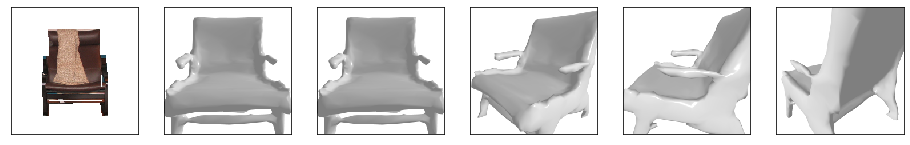

0001 -- corrected
{'azim': 89.44867213315013, 'dist': 1.4615384340286255, 'elev': 17.17041743604927}


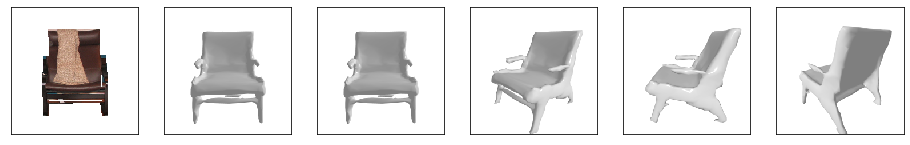

0003 -- uncorrected
{'azim': 111.12171601818122, 'dist': 1.0, 'elev': 24.224421047199193}


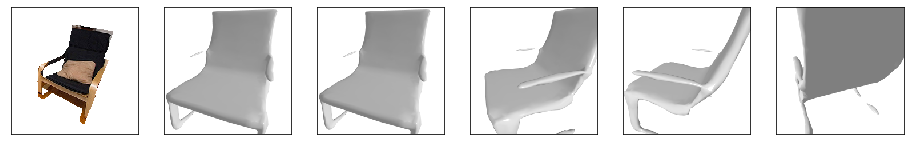

0003 -- corrected
{'azim': 111.12171601818122, 'dist': 1.4615384340286255, 'elev': 24.224421047199193}


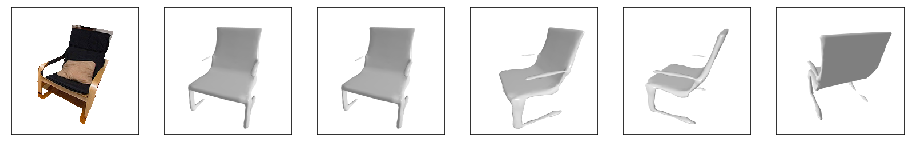

0007 -- uncorrected
{'azim': 102.0486616921662, 'dist': 1.0, 'elev': 22.60643338220855}


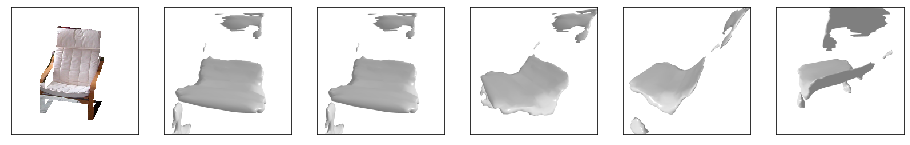

0007 -- corrected
{'azim': 102.0486616921662, 'dist': 1.3974359035491943, 'elev': 22.60643338220855}


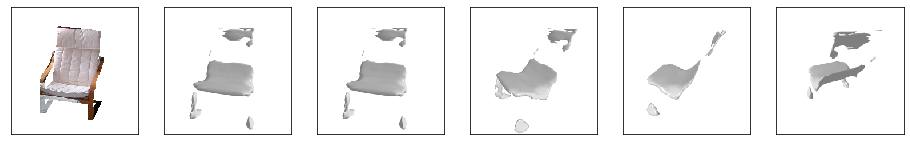

0009 -- uncorrected
{'azim': 103.43629664511917, 'dist': 1.0, 'elev': 20.66446789929263}


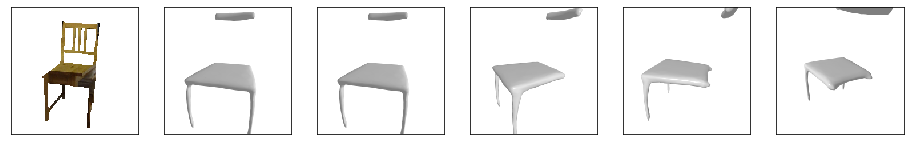

0009 -- corrected
{'azim': 103.43629664511917, 'dist': 1.2692307233810425, 'elev': 20.66446789929263}


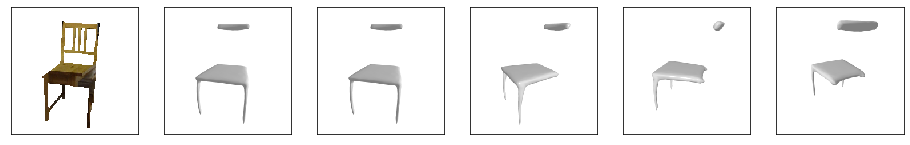

0010 -- uncorrected
{'azim': 68.29837800007627, 'dist': 1.0, 'elev': 14.37587213717931}


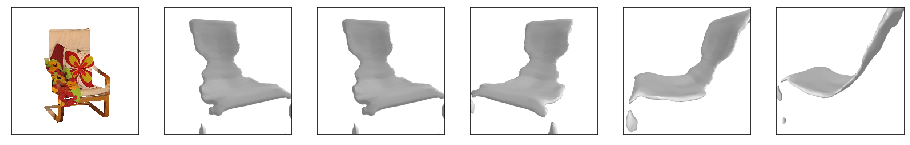

0010 -- corrected
{'azim': 68.29837800007627, 'dist': 1.1410256624221802, 'elev': 14.37587213717931}


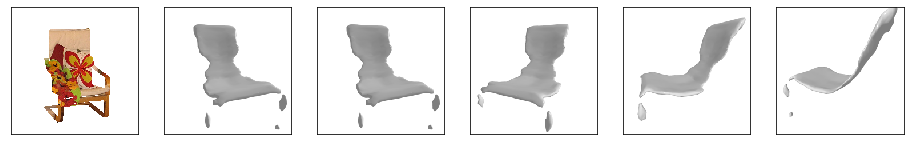

0012 -- uncorrected
{'azim': 73.72162458205182, 'dist': 1.0, 'elev': 12.61645246732533}


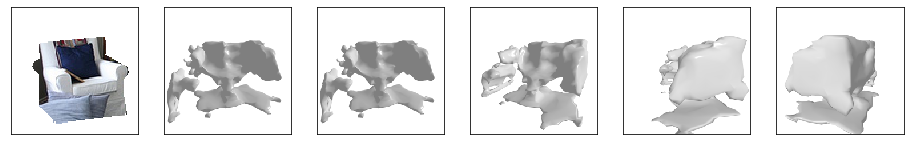

0012 -- corrected
{'azim': 73.72162458205182, 'dist': 1.0128204822540283, 'elev': 12.61645246732533}


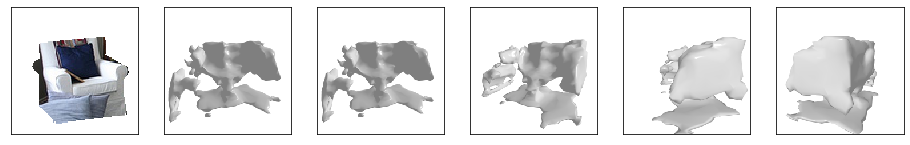

0013 -- uncorrected
{'azim': 110.23291307956623, 'dist': 1.0, 'elev': 14.673895647946424}


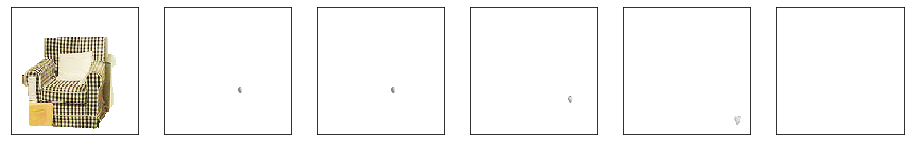

0013 -- corrected
{'azim': 110.23291307956623, 'dist': 0.5, 'elev': 14.673895647946424}


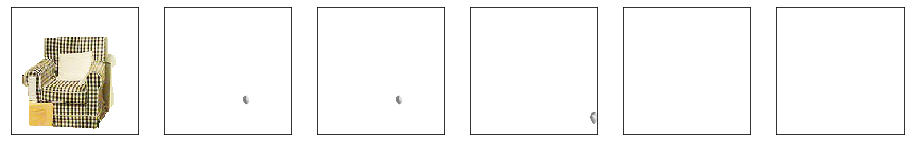

0014 -- uncorrected
{'azim': 108.92098109748443, 'dist': 1.0, 'elev': 13.094078056782744}


ValueError: Split size must be of same length as inputs first dimension

In [11]:
show_num = 20
uncorrected_pred_poses_dict = pickle.load(open(os.path.join(input_dir_img, "renders_camera_params.pt"), "rb"))
corrected_pred_poses_dict = pickle.load(open(os.path.join(input_dir_mesh, "rec_camera_params.pt"), "rb"))

for i, instance in enumerate(corrected_pred_poses_dict):
    input_img_path = os.path.join(input_dir_img,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_dir_mesh,"{}.obj".format(instance))
    input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)
    
    print("{} -- uncorrected".format(instance))
    print(uncorrected_pred_poses_dict[instance])
    dist = uncorrected_pred_poses_dict[instance]["dist"]
    elev = uncorrected_pred_poses_dict[instance]["elev"]
    azim = uncorrected_pred_poses_dict[instance]["azim"]
    visualization_tools.show_refinement_results(input_image, input_mesh, input_mesh, dist, elev, azim, device)
    
    print("{} -- corrected".format(instance))
    print(corrected_pred_poses_dict[instance])
    dist = corrected_pred_poses_dict[instance]["dist"]
    elev = corrected_pred_poses_dict[instance]["elev"]
    azim = corrected_pred_poses_dict[instance]["azim"]
    visualization_tools.show_refinement_results(input_image, input_mesh, input_mesh, dist, elev, azim, device)
    if i > show_num:
        break
    print("======================================================================================================================================================================")
    print("======================================================================================================================================================================")